# Define the libraries

In [81]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from datetime import timedelta
from scipy import signal

# Define the functions 

In [82]:
def PlotData(Begin,Duration,Mistake,OncourtFrame,OncourtVideo,Time,Data1,Data2,Figuur,player,df,arraystartrotate,arraystoprotate): 
    
    #Define starting en stopping positions for the CSV data
    Start = int((((OncourtFrame - OncourtVideo)*100) + Begin/10) - Mistake*100)
    Stop = int(Start + Duration*100)
    
    WheelRotationspeed = Data1[Start:Stop]
    FrameRotationspeed = Data2[Start:Stop]
    Timestamp = Time[Start:Stop]
    
   # -----------------------------------------------------------------------
        #LowPass Filter DON'T TOUCH
    
    #Lowpass filter design for rotation and wheelspeed to improve accuracy of code (Butterworth filter)
    Order = 5 
    cutoff_freq = 1.5
    sampling_freq = 100
    sampling_duration = Duration
    
    normalized_cutoff_freq = 2 * cutoff_freq / sampling_freq
    numerator_coeffs, denominator_coeffs = signal.butter(Order, normalized_cutoff_freq)
    
    filtered_WheelRotationspeed = signal.lfilter(numerator_coeffs, denominator_coeffs, WheelRotationspeed)
    filtered_FrameRotationspeed = signal.lfilter(numerator_coeffs, denominator_coeffs, FrameRotationspeed)
    
    
   # -----------------------------------------------------------------------
        #Operations I have to do for user story   UNDERSTAND WHAT SUB AND CONV TRY TO EXPLAIN
    
    #Play with different operations to see clearer patterns
    Sub = filtered_WheelRotationspeed + filtered_FrameRotationspeed
    
    
    #I'm finally not using conv1 nor Conv_temp
    Conv1 = filtered_FrameRotationspeed / filtered_WheelRotationspeed
    #I set the var below as Conv_temp beause i want to try new calculations
    Conv_temp = (abs(filtered_FrameRotationspeed)+abs(filtered_WheelRotationspeed))/filtered_WheelRotationspeed
    
    
    
    #Conv2 is the one im using finally
    Conv2 = (abs(filtered_FrameRotationspeed)+abs(filtered_WheelRotationspeed))/filtered_WheelRotationspeed
        
    
    
    
    #Diff = arr[i+1] - arr[i]
    number = 8#this variable is for me to only change one number instead of various parameters 1by1
    DiffFrame = np.diff(filtered_FrameRotationspeed,n=number)
    DiffFrame = np.insert(DiffFrame,[0]*number,0)#insert 0 to make the sizes match
    #print(DiffFrame)      
    
    DiffWheel = np.diff(filtered_WheelRotationspeed,n=3)
    DiffWheel = np.insert(DiffWheel,[0]*3,0)
    
    Multi = filtered_WheelRotationspeed + filtered_FrameRotationspeed
    #same as conv but doesn´t see use

  # -----------------------------------------------------------------------
  
    #Visualize operations done (lower row of the subplot)
    fig, ax = plt.subplots(2,2)
    
    ax[1,1].plot(Timestamp,Conv2,'r')
    ax[1,0].plot(Timestamp,abs(DiffFrame),'b')
    
   # -----------------------------------------------------------------------
    
    
    #Set all data into a datafram including Sub, Conv1->Conv, DiffFrame, DiffWheel
    Data = pd.DataFrame({'Time':Timestamp,'WheelRotationspeed':filtered_WheelRotationspeed,
                         'FrameRotationspeed':filtered_FrameRotationspeed,
                         'Sub':Sub ,'Conv':Conv1,'Conv2':Conv2, 'DiffFrame':DiffFrame, 'DiffWheel':DiffWheel}, 
                        columns=['Time', 'WheelRotationspeed','FrameRotationspeed','Sub','Conv', 'Conv2','DiffFrame','DiffWheel'])
    
    # -----------------------------------------------------------------------
    
    
    #Convert data into chunks of n/100 of a second
    n = 50  #chunk row size
    Data_chunks = [Data[i:i+n] for i in range(0,Data.shape[0],n)]
    #when printing the data chunks we see that it prints in sets of 1.5k values
    #those which are divided in sets of 50, this is why we get when asking for max values
    #30 values per iteration
    
    
    #Search for the sprints
    Startsprint = []
    Stopsprint = []
    Sprinting = False
    Stop = True
    

    #print(Data_chunks)
  # -----------------------------------------------------------------------
    #print(Data_chunks['Conv']) isnt possible

    #  Detect Sprints
    
    #Use Sub en Conv to detect sprints
    for chunks in Data_chunks:
        if abs(chunks['Conv'].max()) < 3 and chunks['Sub'].mean() > 300 and Sprinting == False:
            Startsprint.append(chunks['Time'].min())
            Sprinting = True
            Stop = False
        elif abs(chunks['Conv'].max() < 3) and chunks['Sub'].mean() > 300:
            Sprinting = True
            Stop = False
        elif Stop == False:
            Stopsprint.append(chunks['Time'].min())
            Sprinting = False
            Stop = True
    
    
  # -----------------------------------------------------------------------

    #Detect rotation
    
    #Use wheelrotation, framerotation and conv to detect rotations
    Startrotate = []
    Stoprotate = []
    Rotate = False
    Stop = True
    
    count = 0
    
    
    #try adding operations instead of difframe
    for chunks in Data_chunks:
        if abs(chunks['FrameRotationspeed'].max()) > 75 and abs(chunks['Conv2'].mean()) > 1.15 and count!=29 and Rotate == False:
            #this condition count!=29 is to make sure that it doesn't start a rotation in the last
            #point of the graph because that way it would never enc
            
            Startrotate.append(chunks['Time'].min())
            Rotate = True
            Stop = False
        elif abs(chunks['FrameRotationspeed'].max()) > 75 and abs(chunks['Conv2'].mean()) > 1.15 and count == 29 and Rotate == True:
        #this comes due to the need of matching sizes (between startsprint and stopsprint), as in one fast defense
        #theres a rotation that never ends in the plot, so I'm forcing it (had to add Rotate == True so that this condition only 
        #happens when a rotation has started before the last point of the graph)
        
        
            Stoprotate.append(chunks['Time'].min())
            Rotate = False
            Stop = True
        elif abs(chunks['FrameRotationspeed'].max()) > 75 and abs(chunks['Conv2'].mean()) > 1.15:#si abs menor que num sigue siendo rotation 
            #Rotate =True is implicit
            Rotate = True
            Stop = False
        elif Stop == False :#Rotate==True and the previous conditions aren´t met, thats implicit
            Stoprotate.append(chunks['Time'].min())
            Rotate = False
            Stop = True
            
        #print(abs(chunks['Conv2'].mean()))
        print(count, '   ', abs(chunks['Conv2'].mean()))
        #print(count, '   ', chunks['FrameRotationspeed'].max())
        
        count +=1
        #print(count2, count3)
        #    print(count)
        #print(count, '   ', (chunks['FrameRotationspeed'].max()))
        #this prints out the maximum values per
        #set of values on each iterations
    
    #print(Startrotate, Stoprotate)
    
    # -----------------------------------------------------------------------
    
    #Pop small sprints out 
    
    #Filter Sprints by lenght, if length is below 2 delete sprint
    Deleted = 0
    
    if len(Startsprint) > len(Stopsprint):
        Startsprint.pop(-1)
    
    if len(Startsprint) == len(Stopsprint):
        for i in range(0,len(Startsprint)-1):
            if (Stopsprint[i-Deleted] - Startsprint[i-Deleted]) < 2:
                Startsprint.pop(i-Deleted)
                Stopsprint.pop(i-Deleted)
                Deleted = Deleted + 1
    
    
   # -----------------------------------------------------------------------


    #Plot graph
    ax[0,0].plot(Timestamp,WheelRotationspeed,'r',Timestamp,FrameRotationspeed,'b')
    ax[0,1].plot(Timestamp,WheelRotationspeed,'r',Timestamp,FrameRotationspeed,'b')
    #ROJO -> WheelRotationSpeed
    #AZUL -> FrameRotationSpeed
    
  # -----------------------------------------------------------------------
        
    #Plot the vertical lines in plot 1
    for Start in Startsprint:
        ax[0,0].axvline(x=Start, color = 'g')
    for Stop in Stopsprint:
        ax[0,0].axvline(x=Stop, color = 'm')
    #ax[0,0].legend(['Wheel Rotation Speed','Frame Rotation Speed'])
    ax[0,0].set_xlabel('Time (sec)')
    ax[0,0].set_title("Fast Defence " + str(Figuur) + ", " + str(player) + ", Video Time = " 
                      + str(timedelta(seconds=(int(Begin/1000)-Mistake))))
    
    #Plot the vertical lines in plot 2
    for Start in Startrotate:
        ax[0,1].axvline(x=Start, color = 'g')
    for Stop in Stoprotate:
        ax[0,1].axvline(x=Stop, color = 'm')
    
    ArrayStartRotate.append(Startrotate)
    ArrayStopRotate.append(Stoprotate)

# Visualize the data

###      Define player and match

In [83]:
Player = 9
Game = 2

### Insert data player

In [84]:
df_Player = pd.read_csv('matrix_Player_' + str(Player) + '_game_' + str(Game) + '.csv')
df_Player.columns = ['frAcc','frRoAcc','frDispl','frRoAng','frSpeed','timeLine','frameRotationalSpeedX','frameRotationalSpeedY','frameRotationalSpeedZ','wheelRotationalSpeedX','wheelRotationalSpeedY','wheelRotationalSpeedZ','frRoSpeed']
df_Action = pd.read_csv('Ned_DUI_Game_' + str(Game) + '.csv')
df_Player

,frAcc,frRoAcc,frDispl,frRoAng,frSpeed,timeLine,frameRotationalSpeedX,frameRotationalSpeedY,frameRotationalSpeedZ,wheelRotationalSpeedX,wheelRotationalSpeedY,wheelRotationalSpeedZ,frRoSpeed
0,0.000000,0.0,0.0,0.00000,0.000000,0.01,NaN,NaN,NaN,NaN,NaN,NaN,0.00000
1,0.000000,0.0,0.0,0.00000,0.000000,0.02,NaN,NaN,NaN,NaN,NaN,NaN,0.00000
2,0.000000,0.0,0.0,0.00000,0.000000,0.03,NaN,NaN,NaN,NaN,NaN,NaN,0.00000
3,0.000000,0.0,0.0,0.00000,0.000000,0.04,NaN,NaN,NaN,NaN,NaN,NaN,0.00000
4,0.000000,0.0,0.0,0.00000,0.000000,0.05,NaN,NaN,NaN,NaN,NaN,NaN,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
754220,-0.030424,4981.9,6585.3,-0.11980,-0.001860,7542.20,0.97222,2.4578,-0.98778,-0.000000,4.690,2.730,0.25656
754221,0.062668,4981.9,6585.3,-0.11723,-0.002164,7542.20,0.91000,2.5480,-1.05000,-0.056000,4.494,2.597,-1.68370
754222,0.019899,4981.9,6585.2,-0.13407,-0.001537,7542.20,0.92400,2.6320,-1.05000,0.070000,4.620,2.660,NaN
754223,NaN,NaN,NaN,NaN,NaN,NaN,0.96444,2.5200,-1.01890,0.070000,4.620,2.660,NaN


# Define boundaries

## Get timestamps from CSV

In [85]:
df_Action_Player = df_Action.loc[df_Action["Players Group Box"] == ("Player " + str(Player))]
df_Action_Player_Fast_defence = df_Action_Player.loc[df_Action_Player["Player"] == "Fast defence"]#.iloc[::-1]
Timestamp = df_Action_Player_Fast_defence.Position.to_numpy()
print(len(Timestamp))
Timestamp

11


array([ 103920,  282560,  321160,  436840,  509000,  575680,  639320,
        989320, 2495800, 2774320, 4401320])

### Sychronize

Times consist of the oncourt times in the video and the oncourt frames in Matlab

In [86]:
df_Sync = pd.read_csv('Sync_match_' + str(Game) + '.csv')
df_Sync_Player = df_Sync.loc[df_Sync["Player"] == Player]
Times = df_Sync_Player[["Video","Matlab"]].to_numpy()
Times[0][1]

2412.5

In [87]:
Error = [6,6,6,4,6,6,6,6,6,8,8]
print(len(Error))

11


### Visualize

0     1.969467495060507
1     2.182836616578687
2     5.991923378082036
3     1.1196843676732913
4     1.2507257902168631
5     0.3143600825469885
6     1.524516901415387
7     1.1434682880649367
8     1.2697270184001668
9     1.234286620247033
10     1.1278074759173238
11     1.1129939304823697
12     1.0839437959238505
13     1.036128503977102
14     1.010402677447732
15     1.005053039260766
16     1.021952648802172
17     1.034223048434889
18     1.0115041621982899
19     1.0244502434339613
20     1.084722676308874
21     1.188024857130563
22     1.578192746934775
23     1.9903557785172612
24     1.0416260859975706
25     1.1380816482273615
26     1.0320505541735514
27     1.1610269071857917
28     1.2142440757817916
29     1.0787821109935336
0     1.0807016608186546
1     1.207635932533512
2     1.466327009519977
3     1.317185043968545
4     1.2378334863443141
5     0.2630164726274235
6     1.826211670342842
7     0.30221975131671813
8     0.3830235635146881
9     0.3907847033578

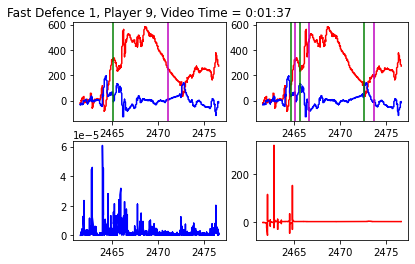

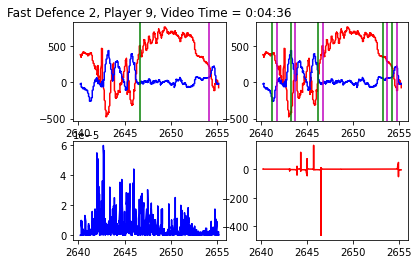

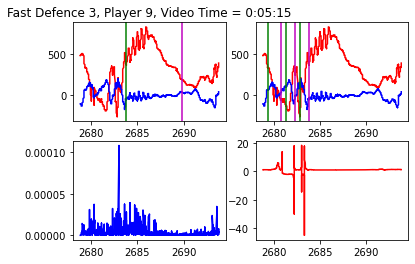

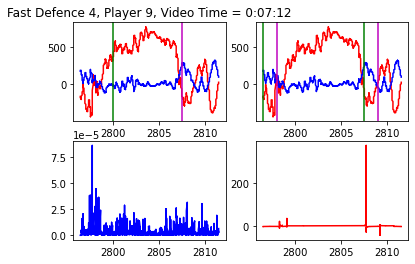

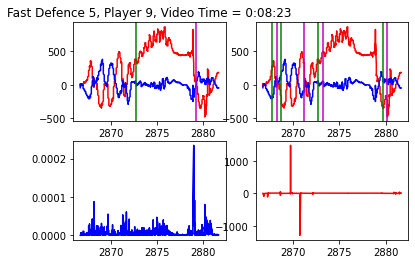

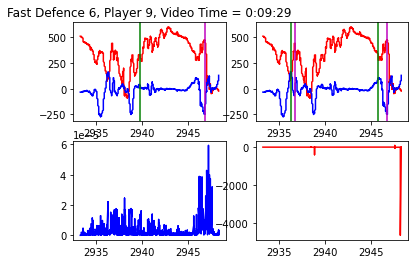

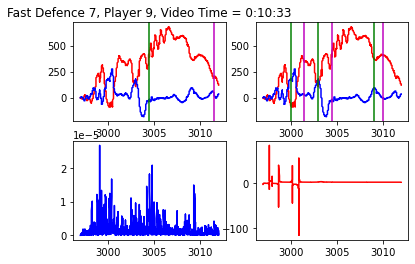

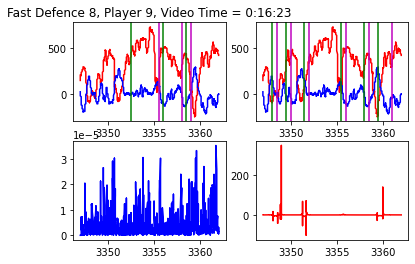

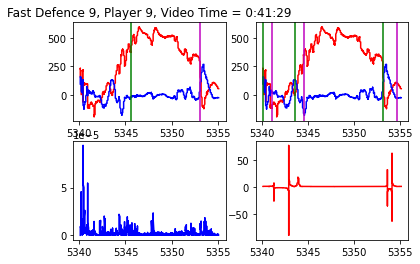

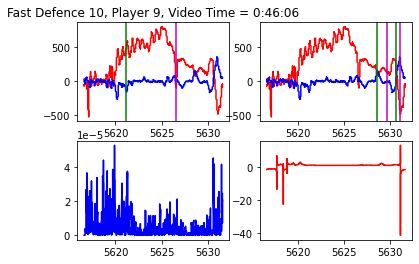

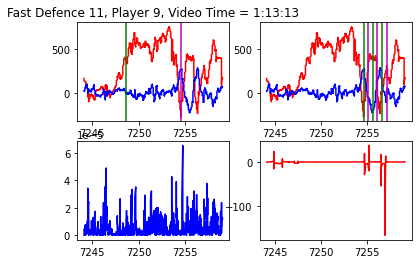

In [88]:
Quator = 0;
count = 0
ArrayStartRotate = []
ArrayStopRotate = []
for i in range(0,len(Timestamp)):#this loop happens 7 times
    if Quator < (len(Times)-1):
        if Timestamp[i] >= (Times[Quator+1][0] * 1000):
            Quator = Quator + 1
    PlotData(Timestamp[i], 15, Error[i], Times[Quator][1], Times[Quator][0], df_Player.timeLine.to_numpy(), 
             df_Player.wheelRotationalSpeedX.to_numpy(), 
             df_Player.frameRotationalSpeedZ.to_numpy(),
             i+1,('Player ' + str(Player)),df_Action, ArrayStartRotate, ArrayStopRotate)
    


In [89]:
Startrotate =[]
Stoprotate = []

for start in ArrayStartRotate:
    for time in start:
        Startrotate.append(time)

for stop in ArrayStopRotate:
    for time in stop:
        Stoprotate.append(time)

print(Startrotate, Stoprotate)

df_Player['Action'] = ""

#There are 9 rotations since the one that doesnt have end
for i  in range(0,len(Startrotate)):
    df_Player['Action'].iloc[int(Startrotate[i]*100-5):int(Stoprotate[i]*100-5)] = 1
   
        
df_Player.to_csv('matrix_Player_' + str(Player) + '_game_' + str(Game) + '_Action.csv')



[2464.6, 2465.6, 2472.6, 2641.2, 2643.2, 2646.2, 2653.2, 2654.2, 2679.3, 2681.3, 2682.8, 2796.5, 2807.5, 2867.7, 2868.7, 2872.7, 2879.7, 2936.3, 2945.8, 3000.0, 3003.0, 3009.0, 3348.0, 3349.5, 3351.5, 3355.5, 3358.0, 3359.5, 5340.1, 5343.6, 5353.1, 5628.6, 5630.6, 7254.6, 7255.6, 7256.6] [2465.1, 2466.6, 2473.6, 2641.7, 2643.7, 2646.7, 2653.7, 2654.7, 2680.8, 2682.3, 2683.8, 2798.0, 2809.0, 2868.2, 2871.2, 2873.2, 2880.2, 2936.8, 2946.8, 3001.5, 3004.5, 3010.0, 3348.5, 3350.0, 3352.0, 3356.0, 3358.5, 3361.0, 5341.1, 5344.6, 5354.6, 5629.6, 5631.1, 7255.1, 7256.1, 7257.1]


/opt/jupyterhub/anaconda/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [90]:
print(len(Stoprotate))

print(len(Startrotate))

36
36
